Rohan Bhatt - MSML604 - HW8

In [ ]:
import numpy as np 
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# initial given problem data
P = np.array([[5, 4, 6],
              [4, 9,15], 
              [6,15,35]], dtype=float)
# linear term in the cost
q = np.array([5, 7, 6], dtype=float)

# rows of Ax ≤ b  (2 inequalities)
A = np.array([[4.0, 0.9, 2.0], 
              [1.3, 0.6, 6.0]])
# right-hand side vector for Ax ≤ b
b = np.array([1.2, 0.8], dtype=float)

#original quadratic objective function f0(x)
def f0(x):
    #returns the scalar obj function 1/2 x^T P x + q^T x
    return 0.5 * x @ P @ x + q @ x 
#log barrier augmented objective 
def barrier(x,t):
    g = np.concatenate([A @ x - b, x-1, -x-1]) #ax - b, xi-1 from xi <= 1, -xi-1 from xi >= -1
    if (g >= 0).any(): #if any inequality is not strict
        return np.inf #return +infinity so its rejected 
    barrier = -np.sum(np.log(-g)) #log barrier term (sum(−log(−g_i(x))))
    return t * f0(x) + barrier #return t times the objective function plus the barrier term

#single equality constraint 1^Tx = 1
equality_constraints = {
    #SLSQP (Sequential Least Squares Quadratic Programming) equality specification
    'type': 'eq', 
    #returs 0 when 1^Tx = 1
    'fun': lambda x: np.sum(x) - 1
}
#strictly feasible starting point x0
x0 = np.array([.05, .90, .05]) #hand picked interior point
#checking Ax < b, -1 < xi < 1, and 1^Tx = 1
assert (A @ x0 < b).all() #, "x0 is not feasible for Ax < b"
assert (np.abs(x0) < 1).all()#, "x0 is not feasible for -1 < xi < 1"
assert np.isclose(np.sum(x0), 1)#, "x0 is not feasible for 1^Tx = 1"
#central path iterations (barrier parameters t)
t_values = [1, 5, 10, 20] #sequence of t values (barier params)
f_history = [] #to store the function values f0(x*(t_k))

for t in t_values: #looping over every t_k:
    solution = minimize(
        #objective function
        barrier, 
        #initial guess
        x0, 
        #passing t into barrier obj
        args=(t,),
        #method to use
        method='SLSQP',
        #equality constraints
        constraints=[equality_constraints],
        #setting tight tolerance with no console output
        options={'disp': False, 'ftol': 1e-12}
    )
    if not solution.success:
        raise RuntimeError(f"Optimization failed: {solution.message}")
    x0 = solution.x #starting next loop with minimiser
    f_history.append(f0(x0)) #recording true objective at x*(t_k)





AssertionError: 

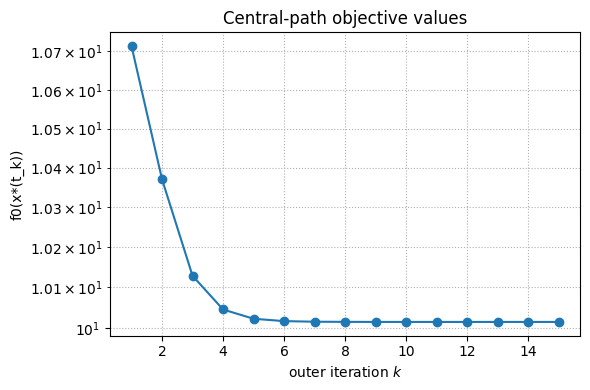

k= 1,  f0=10.7139153563
k= 2,  f0=10.3704326043
k= 3,  f0=10.1286207627
k= 4,  f0=10.0454773381
k= 5,  f0=10.0227630132
k= 6,  f0=10.0169500252
k= 7,  f0=10.0154880865
k= 8,  f0=10.0151220595
k= 9,  f0=10.0149641342
k=10,  f0=10.0149641342
k=11,  f0=10.0149641342
k=12,  f0=10.0149641342
k=13,  f0=10.0149641342
k=14,  f0=10.0149641342
k=15,  f0=10.0149641342
[ 1.2000337 -0.1049634]
[1.2 0.8]


In [ ]:
import numpy as np
from  scipy.optimize import minimize
import matplotlib.pyplot as plt

# initial given problem data
P = np.array([[5, 4, 6],
              [4, 9,15], 
              [6,15,35]], dtype=float)
# linear term in the cost
q = np.array([5, 7, 6], dtype=float)

# rows of Ax ≤ b  (2 inequalities)
A = np.array([[4.0, 0.9, 2.0], 
              [1.3, 0.6, 6.0]])
# right-hand side vector for Ax ≤ b
b = np.array([1.2, 0.8], dtype=float)

# total number of inequality constraints
m = A.shape[0] + 2*3 
# barrier-parameter multiplier  (t_{k+1}=mu·t_k)
mu = 4.0 
# stop when m / t_k < tol_gap
tol_gap = 1e-8
#solver tolerance
ftol = 1e-9  
#helper functions below
def f0(x):
    # original objective 1/2 x^T P x + q^T x
    return 0.5 * x @ P @ x + q @ x

def barrier_and_grad(x, t):
    # Ax <= b -> A_i x − b_i,
    # x <= 1 -> x_k − 1
    # −x <= 1 -> −x_k − 1
    g = np.concatenate((A @ x - b, x - 1, -x - 1))            
    # if x violates any inequality, give a large penalty and zero gradient
    if (g >= 0).any():
        return 1e20, np.zeros_like(x)
    # value phi = t * f0(x) + sum(-log(-g)) 
    phi = t * f0(x) - np.sum(np.log(-g))
    # gradient of original objective
    grad_f0 = t * (P @ x + q)
    # gradient of barrier term
    grad_g  = np.vstack((A, np.eye(3), -np.eye(3)))   
    grad_bar = -grad_g.T @ (1.0 / g)
    return phi, grad_f0 + grad_bar

def phi(x, t):      
    return barrier_and_grad(x, t)[0]
def dphi(x, t):     
    return barrier_and_grad(x, t)[1]

#returs 0 when 1^Tx = 1
eq_constr = {'type': 'eq', 
             'fun': lambda x: np.sum(x) - 1}

#strictly feasible starting point x, known interior point that satisfies: Ax < b, ||x||_infinity < 1, 1^Tx = 1
x0 = np.array([0.08787279, 0.89071102, 0.02141619])

#central path iterations (barrier parameters t)
t = 1.0
f_hist = []

while m / t > tol_gap:
    res = minimize(phi, x0,
                   args   =(t,),
                   jac    =dphi,
                   method ='SLSQP',
                   constraints=[eq_constr],
                   options={'ftol': ftol,
                            'disp': False,
                            'maxiter': 100})

    if not res.success:
        raise RuntimeError(f"SLSQP failed at t={t}: {res.message}")

    x0 = res.x
    f_hist.append(f0(x0))     # store true objective value
    t *= mu                   # increase barrier parameter

plt.figure(figsize=(6, 4))
plt.semilogy(range(1, len(f_hist) + 1), f_hist, marker='o')
plt.xlabel(r'outer iteration $k$')
plt.ylabel('f0(x*(t_k))')
plt.title('Central-path objective values')
plt.grid(True, which='both', ls=':')
plt.tight_layout()
plt.show()


#verifying plot points and ax0 and b points 
for k,v in enumerate(f_hist,1):
    print(f"k={k:2d},  f0={v:.10f}")
print(A @ x0)
print(b)


In [19]:
print("optimal x* =", x0)                 # final iterate
print("Ax*      =", A @ x0, "<", b)       # inequalities
print("1^T x*   =", np.sum(x0))           # equality
print("||Ax*-b||_∞ =", np.max(A @ x0 - b))

optimal x* = [ 0.15000887  0.9999855  -0.14999437]
Ax*      = [ 1.2000337 -0.1049634] < [1.2 0.8]
1^T x*   = 1.0000000000000002
||Ax*-b||_∞ = 3.370263486779379e-05
